<a href="https://colab.research.google.com/github/CamiloZC/IA_DL_Portrait_Classificator/blob/main/Portrait_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importe de librerías necesarias

In [1]:
from sklearn.datasets import load_files       
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import glob
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D,MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import np_utils
import pandas as pd
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD

#Creación de una red neuronal propia

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Data/rgb.zip"

replace rgb/other/00000000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


##Definiciones

Todas las imagenes son de 128x128
* epocs: numero de veces de iteraciones sobre nuestro set de datos de entrenamiento
* batch_size: numero de imagenes a procesar en cada uno de los pasos
* pasos=numero de veces que se procesa la informacion en cada una de las epocas
* pasos_validacion: numero de veces que se procesa el set de validacion
* filtros: despues de una convolucion, esto indica la profundidad de la imagen

## Tramiento de datos
Como nuestro dataset es binario, vamos a definir 0 para "Portrait" y 1 para "NonPortrait"

In [4]:
Portrait_train = np.array(glob.glob('/content/rgb/portrait/*.png'))
NonPortrait_train=np.array(glob.glob('/content/rgb/other/*.png'))

labels_train_Portrait=np.array([0 for fname in Portrait_train])
labels_train_NonPortrait=np.array([1 for fname in NonPortrait_train])

labels_Portrait=np.array(['Portrait' for fname in Portrait_train])
labels_NonPortrait=np.array(['NonPortrait' for fname in NonPortrait_train])



fnames_train = np.concatenate((Portrait_train, NonPortrait_train), axis = 0)
labels_train= np.concatenate((labels_train_Portrait, labels_train_NonPortrait), axis = 0)
labels= np.concatenate((labels_Portrait, labels_NonPortrait), axis = 0)

print(len(fnames_train))
print(len(labels_train))
print(len(labels))

44208
44208
44208


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Portrait and Non Portrait')

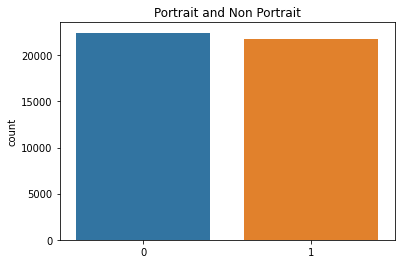

In [5]:
sns.countplot(labels_train)
plt.title('Portrait and Non Portrait')

(128, 128, 3)


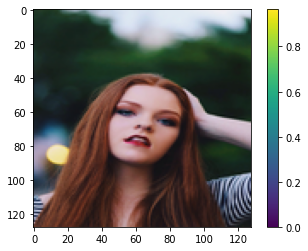

In [6]:
img = plt.imread(fnames_train[6])
print(img.shape)
plt.imshow(img)
plt.grid(False)
plt.colorbar()

##Cargamos los datos con ImageDataGenerator

In [7]:
df=pd.DataFrame({'images':fnames_train, 'class':labels})
from sklearn.utils import shuffle
df = shuffle(df).reset_index()
df = df.drop("index", axis = 1)
df

,images,class
0,/content/rgb/other/00000414_(2).png,NonPortrait
1,/content/rgb/portrait/09836.png,Portrait
2,/content/rgb/other/dog_0139.png,NonPortrait
3,/content/rgb/portrait/03808.png,Portrait
4,/content/rgb/portrait/06020.png,Portrait
...,...,...
44203,/content/rgb/other/car_0883.png,NonPortrait
44204,/content/rgb/other/00000753_(3).png,NonPortrait
44205,/content/rgb/portrait/17672.png,Portrait
44206,/content/rgb/portrait/15259.png,Portrait


In [8]:
#el rescalamiento lo que hace es que como los pixeles van de un valor de 0 a 255 al hacer el rescale los pixeles tienen valores de 0 a 1 que
#es matematicamente mas facil de procesar
# es posible agregar otro valores para que sea mas complejo nuestro analisis como el hear,zsoom y flip (opcional)
datagen=ImageDataGenerator(rescale=1./255., validation_split=0.25, shear_range = 0.15, width_shift_range = 0.2, height_shift_range = 0.2, vertical_flip=True, zoom_range = 0.1)

In [9]:
train_generator=datagen.flow_from_dataframe(
dataframe=df,
x_col="images",
y_col="class",
subset="training",
batch_size=64,
seed=5,
shuffle=True,
class_mode='binary',
target_size=(64,64))

Found 33156 validated image filenames belonging to 2 classes.


In [10]:
validation_generator=datagen.flow_from_dataframe(
dataframe=df,
x_col="images",
y_col="class",
subset="validation",
batch_size=64,
seed=5,
shuffle=False,
class_mode='binary',
target_size=(64,64))

Found 11052 validated image filenames belonging to 2 classes.


## Creamos método de callback para calibrar la accuracy de los modelos

In [11]:
epochs=10
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95 and   logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.90:
          print("\nReached 95% accuracy so cancelling training!")
          self.model.stop_training = True

callbacks = myCallback()

## Creamos el modelo de red neuronal

In [12]:
#Estamos diciendo que nuestra red es secuencial, varia capas apiladas una tras de otra
portraitClassifier = Sequential()
#32 es el tamaño del batch, es decir, cuantas imagenes procesa antes de ajustar pesos, el (3,3) indica el tamaño del filtro, es decir va cojer 3x3 pixeles para hacer la convolucion,
#en otras palabras, coje 9 pixeles y se saca valores y patrones relevantes
portraitClassifier.add(Conv2D(32, (3, 3), input_shape = (64, 64,3), activation = 'relu'))
#el tamaño del filtro de max pulling va ser 2x2, es decir a los valores y patrones anteriores va cojer solo 1 (el maximo) de los 4 pixeles y lo pasa
#a la siguiente capa
portraitClassifier.add(MaxPooling2D(pool_size = (2, 2)))

portraitClassifier.add(Conv2D(64, (2, 2), activation = 'relu'))
portraitClassifier.add(MaxPooling2D(pool_size = (2, 2)))
#esa imagen que es profunda, la volvemos plata con toda la info
portraitClassifier.add(Flatten())
#despues de aplanar se agregan las neuronas de procesamiento o entrada
portraitClassifier.add(Dense(units = 128, activation = 'relu'))

#------lo que hacemos con el dropout es que en cada paso se apagan el 50% de las neuronas
#con el fin de no sobrea ajustar, sobre todo cuando tenemos muchas neuronas y pocos datos
#(se puede usar o no opcional)
# portraitClassifier.add(Dropout(0.1))
#Capa de salida
portraitClassifier.add(Dense(units = 1, activation = 'sigmoid'))
portraitClassifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
historyClassifier = portraitClassifier.fit(train_generator, callbacks = [callbacks], epochs = epochs,validation_data = validation_generator)

Epoch 1/10
519/519 [==============================] - 107s 189ms/step - loss: 0.4730 - accuracy: 0.7740 - val_loss: 0.3532 - val_accuracy: 0.8466
Epoch 2/10
519/519 [==============================] - 88s 169ms/step - loss: 0.3459 - accuracy: 0.8476 - val_loss: 0.2971 - val_accuracy: 0.8720
Epoch 3/10
519/519 [==============================] - 87s 167ms/step - loss: 0.2888 - accuracy: 0.8770 - val_loss: 0.2851 - val_accuracy: 0.8805
Epoch 4/10
519/519 [==============================] - 90s 173ms/step - loss: 0.2556 - accuracy: 0.8934 - val_loss: 0.2428 - val_accuracy: 0.9002
Epoch 5/10
519/519 [==============================] - 87s 167ms/step - loss: 0.2330 - accuracy: 0.9061 - val_loss: 0.2167 - val_accuracy: 0.9079
Epoch 6/10
519/519 [==============================] - 87s 167ms/step - loss: 0.2142 - accuracy: 0.9130 - val_loss: 0.1961 - val_accuracy: 0.9215
Epoch 7/10
519/519 [==============================] - 87s 168ms/step - loss: 0.1994 - accuracy: 0.9185 - val_loss: 0.2128 - val_a

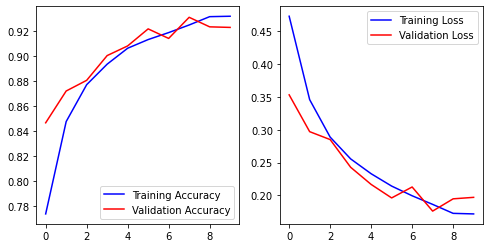

In [14]:
acc=historyClassifier.history['accuracy']
val_acc=historyClassifier.history['val_accuracy']
epoch=range(len(acc))
loss=historyClassifier.history['loss']
val_loss=historyClassifier.history['val_loss']
f,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(epoch,acc,'blue',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'red',label='Validation Accuracy')
ax[0].legend()
ax[1].plot(epoch,loss,'blue',label='Training Loss')
ax[1].plot(epoch,val_loss,'red',label='Validation Loss')
ax[1].legend()
plt.show()

In [15]:
predictions = portraitClassifier.predict(validation_generator)
predictions_label=[0 if p<0.5 else 1 for p in predictions]

173/173 [==============================] - 21s 121ms/step


In [16]:
validation_generator.class_indices

{'NonPortrait': 0, 'Portrait': 1}

In [17]:
true_label = validation_generator.labels
validation_images =validation_generator.filepaths

Check manual de los labels y del validation accuracy:

In [18]:
print(predictions_label)
print(true_label)
true = 0
for i, p in enumerate(predictions_label):
  if predictions_label [i] == true_label[i]:
    true+=1
print(len(predictions_label))
print(true)
print(true/len(predictions_label))

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 

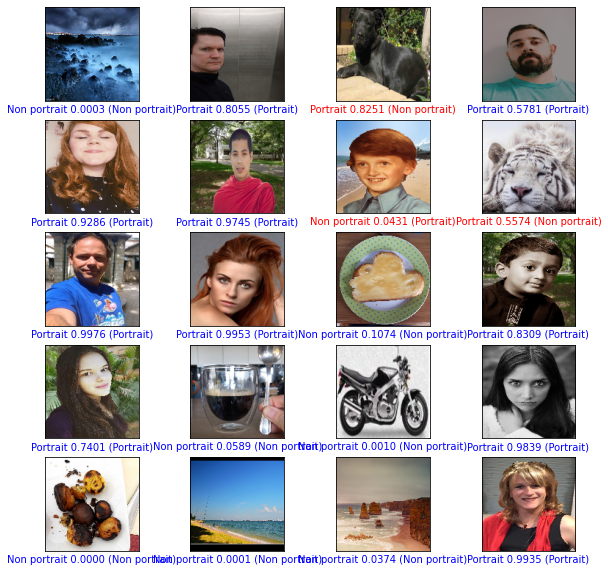

In [19]:
plt.figure(figsize=(10,10))
for index_image in range(20):
  plt.subplot(5, 4, index_image+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  im=plt.imread(validation_images[index_image])
  plt.imshow(im)

  predicted_label = "Non portrait" if predictions[index_image][0]<0.5 else "Portrait"
  real_label="Non portrait" if true_label[index_image]==0 else "Portrait"
  color= 'blue' if predicted_label == real_label else 'red'
  plt.xlabel("{} {:2.0f} ({})".format(predicted_label,
                                predictions[index_image][0],
                                real_label))
  plt.xlabel(f'{predicted_label} {np.max(predictions[index_image][0]):.4f} ({real_label})', color=color)

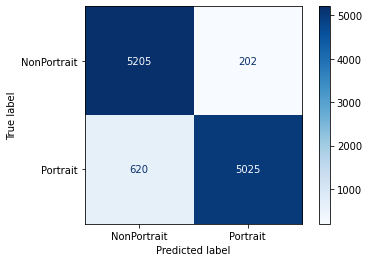

In [20]:
cm = confusion_matrix(true_label, predictions_label)
train_generator.class_indices
classes=list(train_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

# Transferencia de aprendizaje (usando otras redes entrenadas)

##Organización de los datos en otra estructura de carpetas

Separación de los datos en dos carpetas llamadas "train" y "test", dentro de cada carpeta hay dos carpetas más llamadas "portrait" y "others" donde se encuentran respectivamente las dos categorías de imágenes

In [21]:
'/content/rgb/portrait/*.png'
#Hacemos la separacion de carpetas de test y entrenamiento
dataset_home = '/content/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	labeldirs = ['portrait/', 'others/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
  
seed(1)
val_ratio = 0.25
src_directory='/content/rgb/other';
for file in listdir(src_directory):
	src= src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	dst = dataset_home + dst_dir + 'others/'  + file
	copyfile(src, dst)

src_directory='/content/rgb/portrait';
for file in listdir(src_directory):
	src= src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	dst = dataset_home + dst_dir + 'portrait/'  + file
	copyfile(src, dst)

##Creación de objetos que separan de datos para test y train

In [22]:
batch_size=32
train_it = datagen.flow_from_directory('/content/train', class_mode='binary', batch_size=batch_size, target_size=(64, 64))
test_it = datagen.flow_from_directory('/content/test', class_mode='binary', batch_size=batch_size, target_size=(64, 64),shuffle=False)

Found 33085 images belonging to 2 classes.
Found 11123 images belonging to 2 classes.


##ResNet50

In [23]:
base_model=ResNet50(include_top=False, pooling='max', weights='imagenet')
for layer in base_model.layers:
  layer.trainable = False
x = base_model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)
modelResNet50 = Model(inputs=base_model.input, outputs=predictions)
modelResNet50.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [24]:
epochs=5
history = modelResNet50.fit(train_it, callbacks = [callbacks], steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/5
1034/1034 [==============================] - 107s 100ms/step - loss: 0.6232 - accuracy: 0.6531 - val_loss: 0.6290 - val_accuracy: 0.6391
Epoch 2/5
1034/1034 [==============================] - 99s 95ms/step - loss: 0.5837 - accuracy: 0.6941 - val_loss: 0.5612 - val_accuracy: 0.7113
Epoch 3/5
1034/1034 [==============================] - 107s 103ms/step - loss: 0.5727 - accuracy: 0.6974 - val_loss: 0.5559 - val_accuracy: 0.7121
Epoch 4/5
1034/1034 [==============================] - 103s 100ms/step - loss: 0.5657 - accuracy: 0.7067 - val_loss: 0.5755 - val_accuracy: 0.6839
Epoch 5/5
1034/1034 [==============================] - 99s 95ms/step - loss: 0.5510 - accuracy: 0.7191 - val_loss: 0.6066 - val_accuracy: 0.6652


In [25]:
predictions = modelResNet50.predict(test_it)
predictions_label=[0 if p<0.5 else 1 for p in predictions]
true_label = test_it.labels
validation_images =test_it.filepaths

348/348 [==============================] - 25s 70ms/step


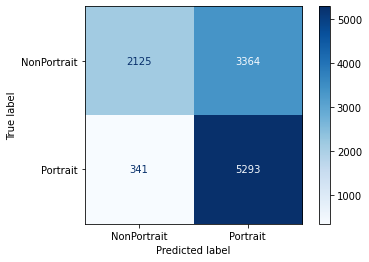

In [26]:
cmResNet50 = confusion_matrix(true_label, predictions_label)
train_generator.class_indices
classes=list(train_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cmResNet50, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [27]:
accuracyResNet50 = np.trace(cmResNet50) / float(np.sum(cmResNet50))
errorResNet50 = 1 - accuracyResNet50
print(accuracyResNet50, errorResNet50)

0.6669064101411489 0.33309358985885107


##VGG16

In [28]:
model = VGG16(include_top=False, input_shape=(64, 64, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

modelVGG16 = Model(inputs=model.inputs, outputs=output)

opt = SGD(lr=0.001, momentum=0.9)
modelVGG16.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [29]:
epochs=10
history = modelVGG16.fit(train_it, callbacks = [callbacks], steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/10
1034/1034 [==============================] - 99s 95ms/step - loss: 0.3455 - accuracy: 0.8465 - val_loss: 0.2867 - val_accuracy: 0.8779
Epoch 2/10
1034/1034 [==============================] - 93s 90ms/step - loss: 0.2678 - accuracy: 0.8864 - val_loss: 0.2511 - val_accuracy: 0.8918
Epoch 3/10
1034/1034 [==============================] - 94s 91ms/step - loss: 0.2466 - accuracy: 0.8954 - val_loss: 0.2358 - val_accuracy: 0.9053
Epoch 4/10
1034/1034 [==============================] - 97s 94ms/step - loss: 0.2375 - accuracy: 0.8989 - val_loss: 0.2452 - val_accuracy: 0.8955
Epoch 5/10
1034/1034 [==============================] - 94s 91ms/step - loss: 0.2250 - accuracy: 0.9058 - val_loss: 0.2233 - val_accuracy: 0.9063
Epoch 6/10
1034/1034 [==============================] - 94s 91ms/step - loss: 0.2182 - accuracy: 0.9105 - val_loss: 0.2106 - val_accuracy: 0.9150
Epoch 7/10
1034/1034 [==============================] - 97s 94ms/step - loss: 0.2110 - accuracy: 0.9123 - val_loss: 0.2085 -

In [30]:
predictions = modelVGG16.predict(test_it)
predictions_label=[0 if p<0.5 else 1 for p in predictions]
true_label = test_it.labels
validation_images =test_it.filepaths

348/348 [==============================] - 24s 68ms/step


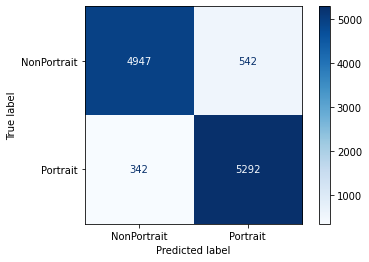

In [31]:
cmVGG16 = confusion_matrix(true_label, predictions_label)
train_generator.class_indices
classes=list(train_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cmVGG16, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [32]:
accuracyVGG16 = np.trace(cmVGG16) / float(np.sum(cmVGG16))
errorVGG16 = 1 - accuracyVGG16
print(accuracyVGG16, errorVGG16)

0.9205250382091162 0.07947496179088376


##VGG19

In [33]:
model = VGG19(include_top=False, input_shape=(64, 64, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)

modelVGG19 = Model(inputs=model.inputs, outputs=output)

opt = SGD(learning_rate=0.001, momentum=0.9)
modelVGG19.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 1s 0us/step


In [34]:
epochs=10
history = modelVGG19.fit(train_it, callbacks = [callbacks], steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/10
1034/1034 [==============================] - 97s 93ms/step - loss: 0.3871 - accuracy: 0.8247 - val_loss: 0.3193 - val_accuracy: 0.8616
Epoch 2/10
1034/1034 [==============================] - 98s 95ms/step - loss: 0.3113 - accuracy: 0.8662 - val_loss: 0.3228 - val_accuracy: 0.8608
Epoch 3/10
1034/1034 [==============================] - 98s 95ms/step - loss: 0.2866 - accuracy: 0.8762 - val_loss: 0.2640 - val_accuracy: 0.8872
Epoch 4/10
1034/1034 [==============================] - 96s 92ms/step - loss: 0.2724 - accuracy: 0.8824 - val_loss: 0.2651 - val_accuracy: 0.8905
Epoch 5/10
1034/1034 [==============================] - 96s 93ms/step - loss: 0.2634 - accuracy: 0.8888 - val_loss: 0.2694 - val_accuracy: 0.8844
Epoch 6/10
1034/1034 [==============================] - 99s 95ms/step - loss: 0.2562 - accuracy: 0.8901 - val_loss: 0.2470 - val_accuracy: 0.8971
Epoch 7/10
1034/1034 [==============================] - 96s 93ms/step - loss: 0.2514 - accuracy: 0.8923 - val_loss: 0.2754 -

In [35]:
predictions = modelVGG19.predict(test_it)
predictions_label=[0 if p<0.5 else 1 for p in predictions]
true_label = test_it.labels
validation_images =test_it.filepaths

348/348 [==============================] - 24s 69ms/step


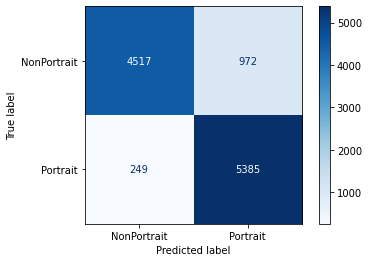

In [36]:
cmVGG19 = confusion_matrix(true_label, predictions_label)
train_generator.class_indices
classes=list(train_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cmVGG19, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [37]:
accuracyVGG19 = np.trace(cmVGG19) / float(np.sum(cmVGG19))
errorVGG19 = 1 - accuracyVGG19
print(accuracyVGG19, errorVGG19)

0.8902274566214151 0.10977254337858489


##Inception V3

In [38]:
batch_size=16
train_it = datagen.flow_from_directory('/content/train', class_mode='binary', batch_size=batch_size, target_size=(128, 128))
test_it = datagen.flow_from_directory('/content/test', class_mode='binary', batch_size=batch_size, target_size=(128, 128),shuffle=False)

Found 33085 images belonging to 2 classes.
Found 11123 images belonging to 2 classes.


In [40]:
model = InceptionV3(include_top=False, input_shape=(128, 128, 3))
for layer in model.layers:
  layer.trainable = False
x = Flatten()(model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(1, activation='sigmoid')(x)
modelInceptionV3 = Model(inputs=model.inputs, outputs=output)
modelInceptionV3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
epochs=5
history = modelInceptionV3.fit(train_it, steps_per_epoch=len(train_it),
                              validation_data=test_it, validation_steps=len(test_it), 
                              epochs=epochs, verbose=1)

Epoch 1/5
2068/2068 [==============================] - 225s 109ms/step - loss: 0.0634 - accuracy: 0.9818 - val_loss: 0.0566 - val_accuracy: 0.9827
Epoch 2/5
2068/2068 [==============================] - 218s 105ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.0696 - val_accuracy: 0.9802
Epoch 3/5
2068/2068 [==============================] - 218s 105ms/step - loss: 0.0535 - accuracy: 0.9841 - val_loss: 0.0576 - val_accuracy: 0.9809
Epoch 4/5
2068/2068 [==============================] - 227s 110ms/step - loss: 0.0530 - accuracy: 0.9845 - val_loss: 0.0544 - val_accuracy: 0.9831
Epoch 5/5
2068/2068 [==============================] - 218s 105ms/step - loss: 0.0525 - accuracy: 0.9849 - val_loss: 0.0555 - val_accuracy: 0.9853


In [42]:
predictions = modelInceptionV3.predict(test_it)
predictions_label=[0 if p<0.5 else 1 for p in predictions]
true_label = test_it.labels
validation_images =test_it.filepaths

696/696 [==============================] - 58s 82ms/step


In [43]:
test_it.class_indices

{'others': 0, 'portrait': 1}

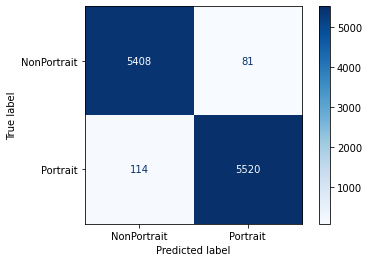

In [44]:
cmInceptionV3 = confusion_matrix(true_label, predictions_label)
train_generator.class_indices
classes=list(train_generator.class_indices.keys())
disp = ConfusionMatrixDisplay(confusion_matrix=cmInceptionV3, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)

In [45]:
accuracyInceptionV3 = np.trace(cmInceptionV3) / float(np.sum(cmInceptionV3))
errorInceptionV3 = 1 - accuracyInceptionV3
print(accuracyInceptionV3, errorInceptionV3)

0.9824687584284815 0.01753124157151853


#Método para probar una imagen específica (con la red neuronal propia)

1/1 [==============================] - 0s 102ms/step
[[0.]]
[0]
No es un retrato


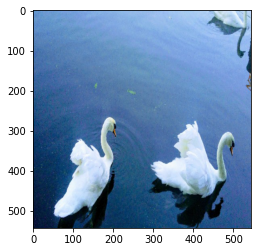

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def predict_specific_image(file):
  x = load_img(file, target_size=(64, 64))
  x = img_to_array (x)
  x = np.expand_dims(x, axis = 0)
  img = mpimg.imread(file)
  imgplot = plt.imshow(img)

  arreglo = portraitClassifier.predict(x)
  print(arreglo)
  resultado = [0 if p<0.5 else 1 for p in arreglo]
  print(resultado)
  if resultado[0] < 0.5:
    print('No es un retrato')
  if resultado[0] >= 0.5:
    print('Es un retrato')

predict_specific_image('/content/cisnes.jpg')


1/1 [==============================] - 0s 18ms/step
[[1.]]
[1]
Es un retrato


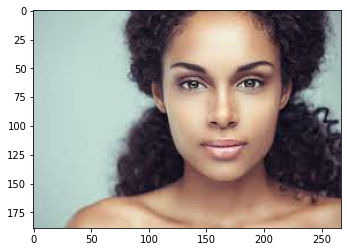

In [48]:
predict_specific_image('/content/retrato.jpg')

1/1 [==============================] - 0s 16ms/step
[[0.]]
[0]
No es un retrato


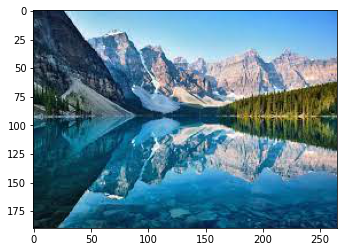

In [51]:
predict_specific_image('/content/a.jpg')

1/1 [==============================] - 0s 16ms/step
[[1.]]
[1]
Es un retrato


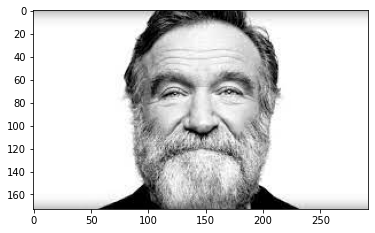

In [52]:
predict_specific_image('/content/retrato2.jpg')

1/1 [==============================] - 2s 2s/step
[[0.]]
[0]
No es un retrato


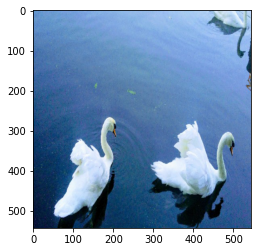

In [53]:
def predict_specific_image_inception(file):
  x = load_img(file, target_size=(128, 128))
  x = img_to_array (x)
  x = np.expand_dims(x, axis = 0)
  img = mpimg.imread(file)
  imgplot = plt.imshow(img)

  arreglo = modelInceptionV3.predict(x)
  print(arreglo)
  resultado = [0 if p<0.5 else 1 for p in arreglo]
  print(resultado)
  if resultado[0] < 0.5:
    print('No es un retrato')
  if resultado[0] >= 0.5:
    print('Es un retrato')

predict_specific_image_inception('/content/cisnes.jpg')

1/1 [==============================] - 0s 25ms/step
[[0.]]
[0]
No es un retrato


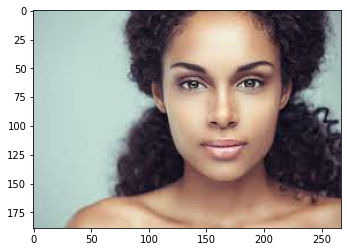

In [54]:
predict_specific_image_inception('/content/retrato.jpg')

1/1 [==============================] - 0s 24ms/step
[[0.]]
[0]
No es un retrato


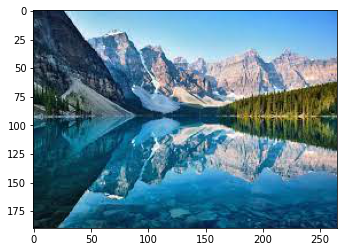

In [55]:
predict_specific_image_inception('/content/a.jpg')

1/1 [==============================] - 0s 25ms/step
[[0.]]
[0]
No es un retrato


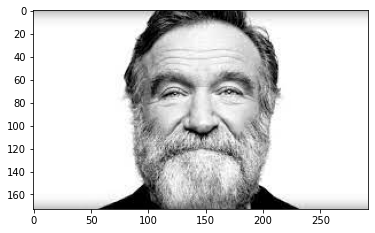

In [56]:
predict_specific_image_inception('/content/retrato2.jpg')

#Conclusión

Está claro que la métrica por excelencia para decidirse por un modelo u  otro es el validation accuracy, es decir, qué tan bien el modelo predijo las imágenes destinadas a validación (o testeo).

En nuestro caso, como se evidencia en el Notebook, el modelo con mayor validation accuracy fue el InceptionV3, con específicamente un valor de 0.9853, sin embargo nos encontramos con que al probar con imágenes externas tiene muchos problemas, creemos que esto es debido a un overfitting, ya que solo en la primera época ya encuentra una accuracy muy alta entonces no logra extraer muchas caracterísiticas genéricas y se ajusta mucho a los datos de entrenamiento.

Como consecuencia a lo anteriormente dicho, nuestro mejor modelo sería el propio, con una validation accuracy de 0.9226.

Debido a esto, para resolver el problema de clasificación de imágenes que son retratos o no, elegiríamos este modelo, con dos capas convolucionales y dos capas de Maxpooling.